<a href="https://colab.research.google.com/github/shreyans-sureja/llm-101/blob/main/26_intro_to_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to LLM Finetuning

 Finetuning: Adapting a pretrained model to a specific task by training the model an additional data.


Instruction finetuning - Training a language on a set of tasks using specific instructions.

 - Ex : Input - Is the following text 'spam'? \
Queen of England want to donate you 1M pound. \
Output - Yes

Classification finetuning - Model is trained to a specific set of labels, such as spam. (without instrcutions)

- Ex : Input - Queen of England want to donate you 1M pound. \
       Output - spam

Instruction finetuning can handle broader set of tasks. At the same time it requires larger datasets and greater computational power.

Parameter Efficient Fine-Tuning(PEFT): form of instruction fine-tuning that is more efficient than full finetuning. PEFT addresses this by updating only a subset of parameters, effectively "freezing" the rest.

This reduces the number of trainable parameters, making memory requirements more manageable and preventing catastropic forgetting.

LoRA (Low Rank Adaption) & QLoRA(Quantized LoRA) are most widely used technique of PEFT.

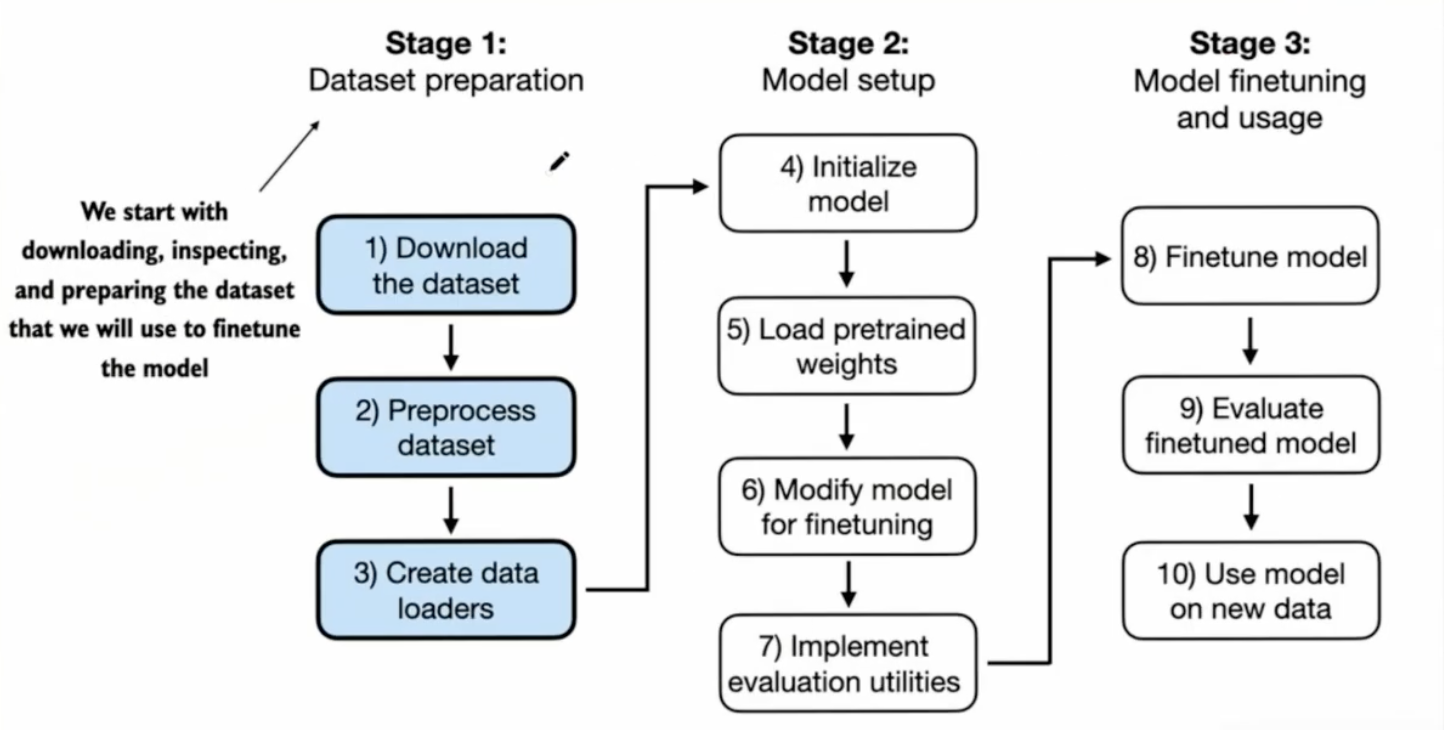

Downloading dataset from here - https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [ ]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [ ]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


For simplicity, and because we prefer a small dataset for educational purposes anyway (it will make it possible to finetune the LLM faster), we subsample (undersample) the dataset so that it contains 747 instances from each class

In [ ]:
def create_balanced_dataset(df):

    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

This process is similar to converting text into token IDs.

However, instead of using the GPT
vocabulary, which consists of more than 50,000 words, we are dealing with just two token
IDs: 0 and 1.

We create a random_split function to split the dataset into three parts: 70% for
training, 10% for validation, and 20% for testing.

(These ratios are common in machine
learning to train, adjust, and evaluate models.)   

In [ ]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

In [ ]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)